# Score Plots

In [1]:
from jaxgeometry.manifolds import Euclidean, nSphere, S1, Landmarks, SPDN, Torus, Latent
from jaxgeometry.setup import dts, jacfwdx, dWs
from jaxgeometry.statistics.score_matching import diffusion_mean
from jaxgeometry.stochastics import Brownian_coords, product_sde, Brownian_sR
from jaxgeometry.stochastics.product_sde import tile
import jaxgeometry.statistics as jstat
import jaxgeometry.stochastics as jstoch
import jax.numpy as jnp
import haiku as hk
import jax
from jax import vmap

from ManLearn.VAE.VAE_MNIST import model as mnist_model
from ManLearn.VAE.VAE_MNIST import model_encoder as mnist_encoder
from ManLearn.VAE.VAE_MNIST import model_decoder as mnist_decoder
from ManLearn.VAE.VAE_MNIST import VAEOutput as mnist_output

from ManLearn.VAE.VAE_SVHN import model as svhn_model
from ManLearn.VAE.VAE_SVHN import model_encoder as svhn_encoder
from ManLearn.VAE.VAE_SVHN import model_decoder as svhn_decoder
from ManLearn.VAE.VAE_SVHN import VAEOutput as svhn_output

from ManLearn.VAE.VAE_CelebA import model as celeba_model
from ManLearn.VAE.VAE_CelebA import model_encoder as celeba_encoder
from ManLearn.VAE.VAE_CelebA import model_decoder as celeba_decoder
from ManLearn.VAE.VAE_CelebA import VAEOutput as celeba_output

from ManLearn.train_MNIST import load_dataset as load_mnist
from ManLearn.train_SVHN import load_dataset as load_svhn
from ManLearn.train_CelebA import load_dataset as load_celeba
from ManLearn.model_loader import load_model

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from jaxgeometry.statistics.score_matching import model_loader
from scores import models

2023-10-13 13:15:21.774236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

## Define Manifolds

In [8]:
loss_type = 'vsm'

In [9]:
def get_coords(M, Fx):
    chart = M.centered_chart(Fx)
    return (M.invF((Fx,chart)),chart)

def to_TM(M, Fx,v):
    x = get_coords(Fx)
#     return jnp.dot(M.JF(x),jnp.dot(M.invJF((Fx,x[1])),v))
    JFx = M.JF(x)
    return jnp.dot(JFx,jnp.linalg.lstsq(JFx,v)[0])

def to_TMx(M, Fx,v):

    x = get_coords(M, Fx)

    return jnp.dot(M.invJF((Fx,x[1])),v)

### $\mathbb{R}^{2}$

In [221]:
R2 = Euclidean(N=2)
jstoch.Brownian_coords(R2)
jstat.diffusion_mean(R2)
R2_x0 = (jnp.zeros(2), jnp.zeros(1))

using M.Exp for Logarithm


In [222]:
file_path = 'scores/R2/'+ loss_type + '/'
r2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_r2 = hk.transform(lambda x: models.MLP_s1(dim=R2.dim, layers=layers)(x))
s2_r2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=R2.dim, r = max(R3.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_r2(x,y,t):
    
    return s1_r2.apply(r2_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_r2(x,y,t):
    
    grad_val = grady_log_r2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_r2(x, y, t)))

def ggrady_log_r2(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1_r2.apply(r2_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

### $\mathbb{R}^{3}$

In [223]:
R3 = Euclidean(N=3)
jstoch.Brownian_coords(R3)
jstat.diffusion_mean(R3)
R3_x0 = (jnp.zeros(3), jnp.zeros(1))

using M.Exp for Logarithm


In [224]:
file_path = 'scores/R3/'+ loss_type + '/'
r3_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_r3 = hk.transform(lambda x: models.MLP_s1(dim=R3.dim, layers=layers)(x))
s2_r3 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=R3.dim, r = max(R3.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_r3(x,y,t):
    
    return s1_r3.apply(r3_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_r3(x,y,t):
    
    grad_val = grady_log_r3(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_r3(x, y, t)))

def ggrady_log_r3(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1_r3.apply(r3_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

### $\mathbb{S}^{1}$

In [242]:
S1M = S1(use_spherical_coords=True)
jstoch.Brownian_coords(S1M)
jstat.diffusion_mean(S1M)
S1M_x0 = S1M.coords([0.])

using M.Exp for Logarithm


In [243]:
file_path = 'scores/S1/'+ loss_type + '/'
s1_state = model_loader.load_model(file_path)
layers = [50, 100, 50]
s1_s1 = hk.transform(lambda x: models.MLP_s1(dim=S1M.dim, layers=layers)(x))
s2_s1 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S1M.dim, r = max(S1M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_s1(x,y,t):
    
    return s1_s1.apply(s1_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_s1(x,y,t):
    
    grad_val = grady_log_s1(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s1(x, y, t)))

def ggrady_log_s1(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1_s1.apply(s1_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

### $\mathbb{S}^{2}$

In [245]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [246]:
file_path = 'scores/S2/'+ loss_type + '/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_s2(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log_s2(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log_s2(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [229]:
S2.F(S2_x0)

Array([0., 0., 1.], dtype=float32)

In [230]:
S2.invF((S2_x0[1], S2_x0[1]))

Array([ 0., -0.], dtype=float32)

### Landmarks 2D

In [231]:
L2 = Landmarks(N=2, m=2)
jstoch.Brownian_coords(L2)
jstat.diffusion_mean(L2)
L2_x0 = L2.coords(jnp.vstack((jnp.linspace(-5.0,5.0,L2.N),jnp.zeros(L2.N))).T.flatten())

using M.Exp for Logarithm


In [232]:
file_path = 'scores/Landmarks2/'+ loss_type + '/'
l2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_l2 = hk.transform(lambda x: models.MLP_s1(dim=L2.dim, layers=layers)(x))
s2_l2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=L2.dim, r = max(L2.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_l2(x,y,t):
    
    return s1_l2.apply(l2_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_l2(x,y,t):
    
    grad_val = grady_log_l2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_l2(x, y, t)))

def ggrady_log_l2(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1_l2.apply(l2_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

### SPDN 2D

In [233]:
SPDN2 = SPDN(N=2)
jstoch.Brownian_coords(SPDN2)
jstat.diffusion_mean(SPDN2)
SPDN2_x0 = SPDN2.coords([0.]*(2*(2+1)//2))

using M.Exp for Logarithm


In [234]:
file_path = 'scores/SPDN2/'+ loss_type + '/'
spdn2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_spdn2 = hk.transform(lambda x: models.MLP_s1(dim=SPDN2.dim, layers=layers)(x))
s2_spdn2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=SPDN2.dim, r = max(SPDN2.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_spdn2(x,y,t):
    
    return s1_spdn2.apply(spdn2_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_spdn2(x,y,t):
    
    grad_val = grady_log_spdn2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_spdn2(x, y, t)))

def ggrady_log_spdn2(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1_spdn2.apply(spdn2_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

### Torus

In [235]:
T2 = Torus()
jstoch.Brownian_coords(T2)
jstat.diffusion_mean(T2)
x0 = T2.coords([0.]*2)

using M.Exp for Logarithm


In [236]:
file_path = 'scores/Torus/'+ loss_type + '/'
t2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_t2 = hk.transform(lambda x: models.MLP_s1(dim=T2.dim, layers=layers)(x))
s2_t2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=T2.dim, r = max(T2.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_t2(x,y,t):
    
    return to_TMx(T2, y[1], s1_t2.apply(t2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log_t2(x,y,t):
    
    grad_val = grady_log_t2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_t2(x, y, t)))

def ggrady_log_t2(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(T2, y[1], s1_t2.apply(t2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

## Comparison to Analytical Gradients

In [237]:
T = 0.5

In [238]:
#Source: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / jnp.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return jnp.arccos(jnp.clip(jnp.dot(v1_u, v2_u), -1.0, 1.0))

### $\mathbb{R}^{2}$

In [239]:
N_points = 1000
min_x = -2.0
max_x = 2.0
x1 = jnp.linspace(min_x, max_x, N_points)
x2 = jnp.linspace(min_x, max_x, N_points)

# Creating the coordinate grid for the unit sphere.
X1_R2, X2_R2 = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_R2.reshape(1, N_points, N_points), 
                     X2_R2.reshape(1, N_points, N_points))), axes=(1,2,0))

theoretical_grad = lambda y: R2.grady_log_hk(R2_x0, (y, jnp.zeros(1)), T)[0]
numerical_grad = lambda y: grady_log_r2(R2_x0, (y, jnp.zeros(1)), T)
R2_grad = vmap(lambda x2: vmap(lambda x1: jnp.linalg.norm(numerical_grad(x1)))(x2))(X_heat)
R2_angle = vmap(lambda x2: vmap(lambda x1: angle_between(theoretical_grad(x1),
                                                         numerical_grad(x1)))(x2))(X_heat)
R2_l2 = vmap(lambda x2: \
                vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1)-numerical_grad(x1))**2)(x2))(X_heat)

### $\mathbb{R}^{3}$

In [240]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere
#Plotting
# Creating the theta and phi values
N_points = 100

min_x = -2.0
max_x = 2.0

x1 = jnp.linspace(min_x, max_x, N_points)
x2 = jnp.linspace(min_x, max_x, N_points)
x3 = jnp.linspace(min_x, max_x, N_points)

# Creating the coordinate grid for the unit sphere.
X1_r3, X2_r3, X3_r3 = jnp.meshgrid(x1, x2, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_r3.reshape(1, N_points,N_points, N_points), 
                     X2_r3.reshape(1, N_points,N_points, N_points),
                                       X3_r3.reshape(1, N_points,N_points, N_points))), axes=(1,2,3,0))

theoretical_grad = lambda y: R3.grady_log_hk(R3_x0, (y, jnp.zeros(1)), T)[0]
numerical_grad = lambda y: grady_log_r3(R3_x0, (y, jnp.zeros(1)), T)
R3_grad = vmap(lambda x3: vmap(lambda x2: vmap(lambda x1: jnp.linalg.norm(numerical_grad(x1)))(x2))(x3))(X_heat)
R3_angle = vmap(lambda x3: vmap(lambda x2: vmap(lambda x1: angle_between(theoretical_grad(x1),
                                                         numerical_grad(x1)))(x2))(x3))(X_heat)
R3_l2 = vmap(lambda x3: \
                vmap(lambda x2: \
                     vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1)-numerical_grad(x1))**2)(x2))(x3))(X_heat)


### $\mathbb{S}^{1}$

In [244]:
# Creating the theta and phi values.
N_points = 1000
phi_heat   = jnp.linspace(0.0, jnp.pi*2, N_points)

# Creating the coordinate grid for the unit sphere.
X1_s1 = jnp.cos(phi_heat)
X2_s1 = jnp.sin(phi_heat)
X_s1 = jnp.transpose(jnp.concatenate((X1_s1.reshape(1, N_points), 
                     X2_s1.reshape(1, N_points))))

theoretical_grad = lambda y: S1M.grady_log_hk(S1M_x0, get_coords(S1M, y), T)
numerical_grad = lambda y: grady_log_s1(S1M_x0, get_coords(S1M, y), T)
S1_grad = vmap(lambda x1: jnp.linalg.norm(numerical_grad(x1)))(X_s1)
S1_angle = vmap(lambda x1: angle_between(theoretical_grad(x1),numerical_grad(x1)))(X_s1)
S1_l2 = vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1)-numerical_grad(x1))**2)(X_s1)

### $\mathbb{S}^{2}$

In [247]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

# Creating the theta and phi values.

# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1_S2 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_S2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_S2 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X_heat = jnp.transpose(jnp.concatenate((X1_S2.reshape(1, ntheta+1, nphi+1), 
                     X2_S2.reshape(1, ntheta+1, nphi+1), 
                     X3_S2.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

theoretical_grad = lambda y: S2.grady_log_hk(S2_x0, get_coords(S2,y), T)[0]
numerical_grad = lambda y: grady_log_s2(S2_x0, get_coords(S2,y), T)
S2_grad = vmap(lambda x2: vmap(lambda x1: jnp.linalg.norm(numerical_grad(x1)))(x2))(X_heat)
S2_angle = vmap(lambda x2: vmap(lambda x1: angle_between(theoretical_grad(x1),
                                                         numerical_grad(x1)))(x2))(X_heat)
S2_l2 = vmap(lambda x2: \
                vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1)-numerical_grad(x1))**2)(x2))(X_heat)

### Comparison of Angle

/tmp/ipykernel_380086/3607513086.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


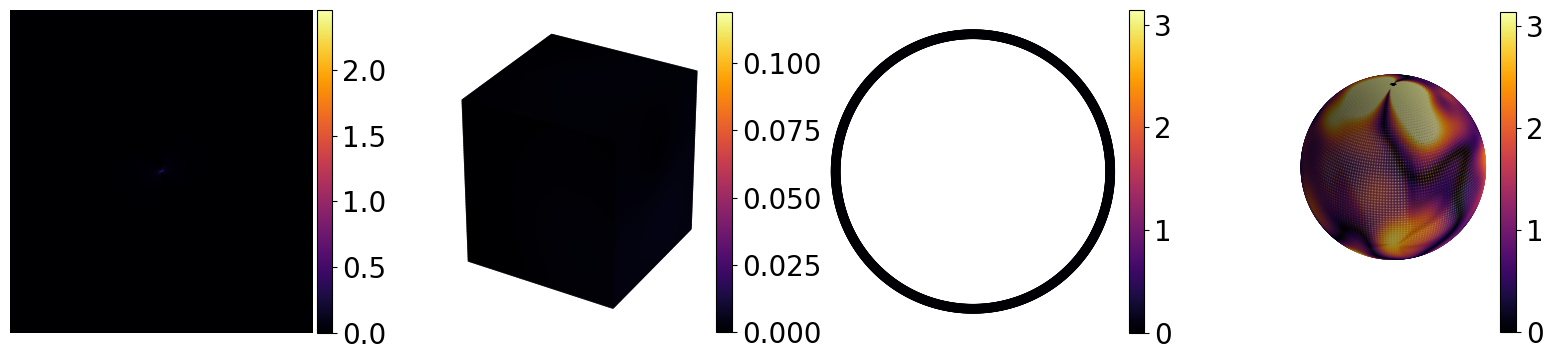

In [248]:
fig = plt.figure(figsize=(16,4))

#R2
ax = fig.add_subplot(1,4,1)
ax.imshow(R2_angle, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(R2_angle)
ax.autoscale(False)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#S1
ax = fig.add_subplot(1,4,3)
ax.scatter(X_s1[:,0], X_s1[:,1], c=S1_angle, cmap=plt.cm.inferno)
ax.set_ylim((-1.1,1.1))
ax.set_xlim((-1.1,1.1))
ax.autoscale(False)
ax.set_box_aspect(1.0)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S1_angle)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#R3
ax = fig.add_subplot(1,4,2, projection='3d')
ax.plot_surface(X1_r3[:,:,0], X2_r3[:,:,0], X3_r3[:,:,0], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[:,:,0]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,:,-1], X2_r3[:,:,-1], X3_r3[:,:,-1], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[:,:,-1]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,0,:], X2_r3[:,0,:], X3_r3[:,0,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[:,0,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,-1,:], X2_r3[:,-1,:], X3_r3[:,-1,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[:,-1,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[0,:,:], X2_r3[0,:,:], X3_r3[0,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[0,:,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[-1,:,:], X2_r3[-1,:,:], X3_r3[-1,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[-1,:,:]*10), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(R3_angle)
divider = make_axes_locatable(ax)
cax = plt.axes([0.46, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

#S2
ax = fig.add_subplot(1,4,4, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, facecolors=plt.cm.inferno(S2_angle*10), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S2_angle)
divider = make_axes_locatable(ax)
cax = plt.axes([0.95, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

fig.tight_layout()

plt.show()

fig.savefig('Figures/comparison_angle.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


### Comparison of L2-Norm

(6, 100, 100)


/tmp/ipykernel_380086/1113095889.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


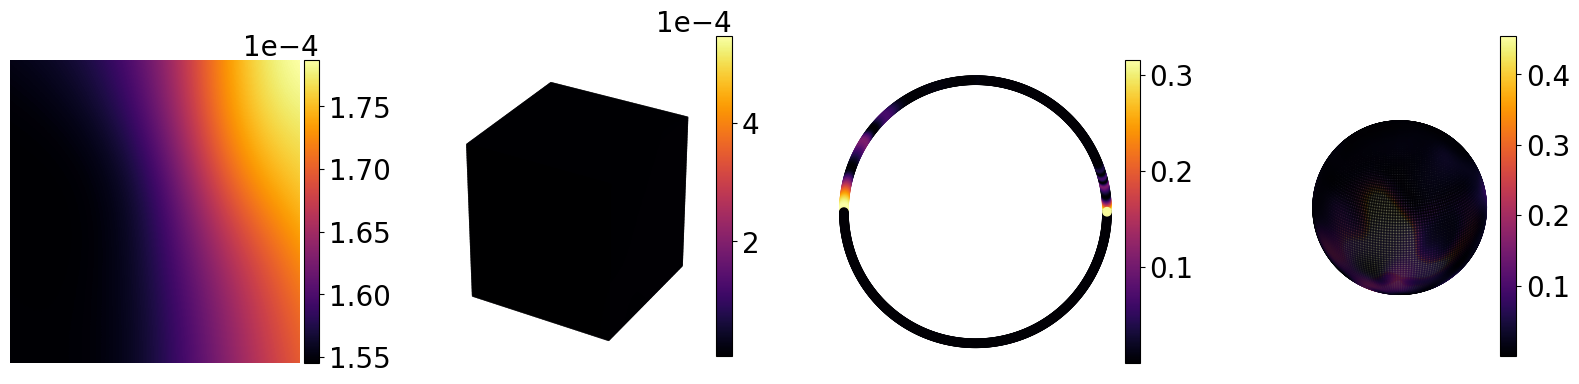

In [251]:
fig = plt.figure(figsize=(16,4))

#R2
ax = fig.add_subplot(1,4,1)
ax.imshow(R2_l2, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(R2_l2)
ax.autoscale(False)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#S1
ax = fig.add_subplot(1,4,3)
ax.scatter(X_s1[:,0], X_s1[:,1], c=S1_l2, cmap=plt.cm.inferno)
ax.set_ylim((-1.1,1.1))
ax.set_xlim((-1.1,1.1))
ax.autoscale(False)
ax.set_box_aspect(1.0)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S1_l2)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#R3
ax = fig.add_subplot(1,4,2, projection='3d')
ax.plot_surface(X1_r3[:,:,0], X2_r3[:,:,0], X3_r3[:,:,0], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_l2[:,:,0]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,:,-1], X2_r3[:,:,-1], X3_r3[:,:,-1], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_l2[:,:,-1]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,0,:], X2_r3[:,0,:], X3_r3[:,0,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_l2[:,0,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,-1,:], X2_r3[:,-1,:], X3_r3[:,-1,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_l2[:,-1,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[0,:,:], X2_r3[0,:,:], X3_r3[0,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_l2[0,:,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[-1,:,:], X2_r3[-1,:,:], X3_r3[-1,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_l2[-1,:,:]*10), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
heat_map = jnp.stack((R3_l2[:,:,0],
                     R3_l2[:,:,-1],
                     R3_l2[:,0,:],
                     R3_l2[:,-1,:],
                     R3_l2[0,:,:],
                     R3_l2[-1,:,:]))
m.set_array(heat_map)
divider = make_axes_locatable(ax)
cax = plt.axes([0.46, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

#S2
ax = fig.add_subplot(1,4,4, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, facecolors=plt.cm.inferno(S2_l2*10), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S2_l2)
divider = make_axes_locatable(ax)
cax = plt.axes([0.95, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

fig.tight_layout()

plt.show()

fig.savefig('Figures/comparison_l2.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


### Plotting Learned Gradient

/tmp/ipykernel_380086/3070281825.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


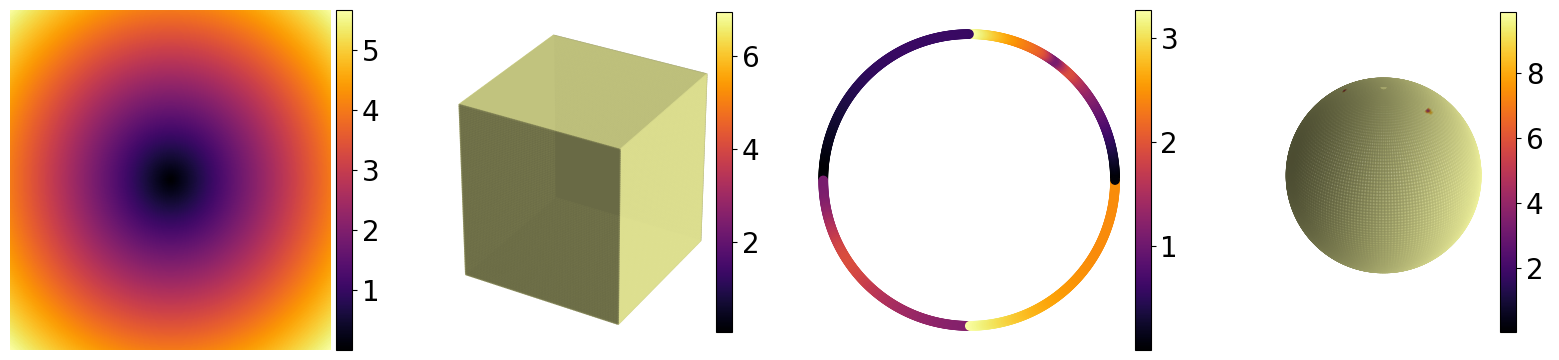

In [216]:
fig = plt.figure(figsize=(16,4))

#R2
ax = fig.add_subplot(1,4,1)
ax.imshow(R2_grad, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(R2_grad)
ax.autoscale(False)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#S1
ax = fig.add_subplot(1,4,3)
ax.scatter(X_s1[:,0], X_s1[:,1], c=S1_grad, cmap=plt.cm.inferno)
ax.set_ylim((-1.1,1.1))
ax.set_xlim((-1.1,1.1))
ax.autoscale(False)
ax.set_box_aspect(1.0)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S1_grad)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#R3
ax = fig.add_subplot(1,4,2, projection='3d')
ax.plot_surface(X1_r3[:,:,0], X2_r3[:,:,0], X3_r3[:,:,0], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[:,:,0]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,:,-1], X2_r3[:,:,-1], X3_r3[:,:,-1], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[:,:,-1]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,0,:], X2_r3[:,0,:], X3_r3[:,0,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[:,0,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,-1,:], X2_r3[:,-1,:], X3_r3[:,-1,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[:,-1,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[0,:,:], X2_r3[0,:,:], X3_r3[0,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[0,:,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[-1,:,:], X2_r3[-1,:,:], X3_r3[-1,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[-1,:,:]*10), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(R3_grad)
divider = make_axes_locatable(ax)
cax = plt.axes([0.46, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

#S2
ax = fig.add_subplot(1,4,4, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, facecolors=plt.cm.inferno(S2_grad*10), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S2_grad)
divider = make_axes_locatable(ax)
cax = plt.axes([0.95, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

fig.tight_layout()

plt.show()

fig.savefig('Figures/comparison_grad.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


## Plotting Synthetic Data

### $\mathbb{S}^{2}$

In [85]:
# Creating the theta and phi values.
N_points = 100
theta = jnp.pi/4
phi = jnp.linspace(0.0, jnp.pi*2, N_points)
X1_circle = jnp.sin(theta)*jnp.cos(phi)
X2_circle = jnp.sin(theta)*jnp.sin(phi)
X3_circle = jnp.cos(theta)*jnp.ones(N_points)
X_circle = jnp.concatenate((X1_circle.reshape(1,-1), X2_circle.reshape(1,-1), X3_circle.reshape(1,-1))).T
X_circle = X_circle[:-1]

X_obs = vmap(lambda x: get_coords(S2, x))(X_circle)

In [86]:
diffusion_mean.initialize(S2, s1_model=grady_log_s2, s2_model = ggrady_log_s2, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = S2.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.5]))

In [88]:
mu_sm

(Array([[-1.16384125e-11, -0.00000000e+00],
        [ 6.96986496e-11, -0.00000000e+00],
        [ 2.38555842e-11, -0.00000000e+00],
        ...,
        [-2.35886954e-09, -0.00000000e+00],
        [-2.35886954e-09, -0.00000000e+00],
        [-2.35886954e-09, -0.00000000e+00]], dtype=float32),
 Array([[ 0.6325749 , -0.00196592,  0.7744966 ],
        [ 0.56592137, -0.00213704,  0.82445633],
        [ 0.5069035 , -0.00100889,  0.86200213],
        ...,
        [ 0.04637057,  0.09685507,  0.99421746],
        [ 0.04637057,  0.09685507,  0.99421746],
        [ 0.04637057,  0.09685507,  0.99421746]], dtype=float32))

In [87]:
diffusion_mean.initialize(S2, s1_model=lambda x,y,t: S2.grady_log_hk(x,y,t)[0], s2_model = lambda x,y,t: jacfwdx(lambda y: S2.grady_log_hk(x,y,t)[0])(y), method="Gradient")
mu_opt, T_opt, _, _ = S2.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.5]))

In [22]:
# run once to compile
%time (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = S2.diffusion_mean(X_obs,num_steps=2)
# run MLE
%time (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = S2.diffusion_mean(X_obs,num_steps=30)

Step 0 | T: 5.405972e+00 | T: ((Array([-0.0541018,  0.0679132], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 4.634086e+00 | T: ((Array([-0.04425116,  0.05803534], dtype=float32), Array(0.21991488, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Final 1 | T: 4.634086e+00 | T: (Array([-0.04425116,  0.05803534], dtype=float32), Array(0.21991488, dtype=float32))
CPU times: user 12 s, sys: 63.5 ms, total: 12.1 s
Wall time: 12 s
Step 0 | T: 5.405969e+00 | T: ((Array([-0.0541018,  0.0679132], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 4.633849e+00 | T: ((Array([-0.04425003,  0.05803493], dtype=float32), Array(0.21991487, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 2 | T: 3.997483e+00 | T: ((Array([-0.03466398,  0.04836811], dtype=float32), Array(0.22969837, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 3 | T: 3.473796e+00 | T: ((Array([-0.02546715,  0.03

In [23]:
mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

In [24]:
diffusion_mean.initialize(S2, s1_model=lambda x,y,t: S2.grady_log_hk(x,y,t)[0], s2_model = lambda x,y,t: jacfwdx(lambda y: S2.grady_log_hk(x,y,t)[0])(y), method="Gradient")
mu_opt, T_opt, _, _ = S2.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.5]))

### Landmarks 2D

In [25]:
# Creating the theta and phi values.
N_points = 100
x1 = jnp.linspace(-5, 5, N_points)
x2 = jnp.linspace(5, -5, N_points)
x3 = jnp.linspace(-3, 3, N_points)
x4 = jnp.linspace(3, -3, N_points)
X_obs = (jnp.stack((x1,x2,x3,x4)).T, jnp.zeros(100))

In [26]:
L2_x0

(Array([-5.,  0.,  5.,  0.], dtype=float32), Array([0.], dtype=float32))

In [27]:
X_obs

(Array([[-5.        ,  5.        , -3.        ,  3.        ],
        [-4.8989897 ,  4.8989897 , -2.939394  ,  2.939394  ],
        [-4.79798   ,  4.79798   , -2.8787878 ,  2.8787878 ],
        [-4.69697   ,  4.69697   , -2.818182  ,  2.818182  ],
        [-4.5959597 ,  4.5959597 , -2.7575758 ,  2.7575758 ],
        [-4.4949493 ,  4.4949493 , -2.6969697 ,  2.6969697 ],
        [-4.3939395 ,  4.3939395 , -2.6363635 ,  2.6363635 ],
        [-4.292929  ,  4.292929  , -2.5757575 ,  2.5757575 ],
        [-4.1919193 ,  4.1919193 , -2.5151515 ,  2.5151515 ],
        [-4.090909  ,  4.090909  , -2.4545455 ,  2.4545455 ],
        [-3.9898992 ,  3.9898992 , -2.3939395 ,  2.3939395 ],
        [-3.8888888 ,  3.8888888 , -2.3333333 ,  2.3333333 ],
        [-3.7878788 ,  3.7878788 , -2.2727273 ,  2.2727273 ],
        [-3.6868687 ,  3.6868687 , -2.2121212 ,  2.2121212 ],
        [-3.5858583 ,  3.5858583 , -2.151515  ,  2.151515  ],
        [-3.4848485 ,  3.4848485 , -2.0909092 ,  2.0909092 ],
        

In [28]:
diffusion_mean.initialize(L2, s1_model=grady_log_l2, s2_model = ggrady_log_l2, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = L2.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.5]))

In [29]:
mu_sm

(Array([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], dtype=float32),
 Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.

In [30]:
# run once to compile
%time (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = L2.diffusion_mean(X_obs,num_steps=2)
# run MLE
%time (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = L2.diffusion_mean(X_obs,num_steps=30)

ValueError: The user-provided objective function must return a scalar value.

ValueError: The user-provided objective function must return a scalar value.

In [31]:
mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

### SPDN 2D

In [20]:
## Creating the theta and phi values.
N_points = 100
theta = jnp.pi/4
X_diag = vmap(lambda x: jnp.eye(2)*x)(jnp.linspace(1, 10, 100))

X_obs = vmap(lambda x: get_coords(SPDN2, x.reshape(-1)))(X_diag)

In [21]:
diffusion_mean.initialize(SPDN2, s1_model=grady_log_spdn2, s2_model = ggrady_log_spdn2, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = SPDN2.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.5]), max_iter=10000)

In [26]:
grad = -jnp.mean(vmap(lambda x,chart: grady_log_spdn2((X_obs[0][0], X_obs[1][0]), (x,chart), jnp.array([0.5])))(X_obs[0], X_obs[1]))
SPDN2.Exp((X_obs[0][0], X_obs[1][0]), grad)

ValueError: All input arrays must have the same shape.

In [47]:
# run once to compile
%time (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = L2.diffusion_mean(X_obs,num_steps=2)
# run MLE
%time (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = L2.diffusion_mean(X_obs,num_steps=30)

ValueError: The user-provided objective function must return a scalar value.

ValueError: The user-provided objective function must return a scalar value.

In [305]:
mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

In [48]:
mu_sm

(Array([[5.5454545, 0.       , 5.5454545],
        [5.5454545, 0.       , 5.5454545],
        [5.5454545, 0.       , 5.5454545],
        ...,
        [5.5454545, 0.       , 5.5454545],
        [5.5454545, 0.       , 5.5454545],
        [5.5454545, 0.       , 5.5454545]], dtype=float32),
 Array([[5.5454545, 0.       , 0.       , 5.5454545],
        [5.5454545, 0.       , 0.       , 5.5454545],
        [5.5454545, 0.       , 0.       , 5.5454545],
        ...,
        [5.5454545, 0.       , 0.       , 5.5454545],
        [5.5454545, 0.       , 0.       , 5.5454545],
        [5.5454545, 0.       , 0.       , 5.5454545]], dtype=float32))

### Torus

In [89]:
xs = pd.read_csv('Data/Torus/xs.csv', header=None)
charts = pd.read_csv('Data/Torus/chart.csv', header=None)
X_obs = (xs.values, charts.values)

In [90]:
diffusion_mean.initialize(T2, s1_model=grady_log_t2, s2_model = ggrady_log_t2, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = T2.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.5]), max_iter=1000)

ValueError: 'mlp_s1/~model/linear/w' with retrieved shape (7, 50) does not match shape=[5, 50] dtype=dtype('float32')

In [91]:
# run once to compile
%time (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = L2.diffusion_mean(X_obs,num_steps=2)
# run MLE
%time (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = L2.diffusion_mean(X_obs,num_steps=30)

ValueError: The user-provided objective function must return a scalar value.

ValueError: The user-provided objective function must return a scalar value.

In [92]:
mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

NameError: name 'mu_bridge' is not defined

In [93]:
mu_sm

(Array([[5.5454545, 0.       , 5.5454545],
        [5.5454545, 0.       , 5.5454545],
        [5.5454545, 0.       , 5.5454545],
        ...,
        [5.5454545, 0.       , 5.5454545],
        [5.5454545, 0.       , 5.5454545],
        [5.5454545, 0.       , 5.5454545]], dtype=float32),
 Array([[5.5454545, 0.       , 0.       , 5.5454545],
        [5.5454545, 0.       , 0.       , 5.5454545],
        [5.5454545, 0.       , 0.       , 5.5454545],
        ...,
        [5.5454545, 0.       , 0.       , 5.5454545],
        [5.5454545, 0.       , 0.       , 5.5454545],
        [5.5454545, 0.       , 0.       , 5.5454545]], dtype=float32))

In [ ]:
# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(X_obs[0][:,0], X_obs[0][:,1], s=10, color='black', label='Observations')
#ax.scatter(mu_true_est[0][:,0], mu_true_est[0][:,1], s=20*t_true_est, color='orange', label=r'$\nabla_{y}\ln p(x,y,t)$')
ax.scatter(mu_sm[0][-1,0], mu_sm[0][-1,1], color='Blue')
ax.scatter(mu_bridgex[-1,0], mu_bridgex[-1,1], color='Red', alpha=0.5)
ax.scatter(mu_opt[0][0], mu_opt[0][1], color='Orange', alpha=0.5)
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
#ax.set_title(r'Diffusion Mean Estimates')
ax.legend(loc='lower center', fontsize=20)
ax.grid()
fig.savefig('Figures/r2_estimates.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

## Synthetic Data Plot

In [21]:
M = nSphere(N=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [22]:
file_path = 'scores/S2/'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50,100,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

## Estimating Diffusion t-Mean

In [23]:
xs = pd.read_csv('Data/S2/xs.csv', header=None)
charts = pd.read_csv('Data/S2/chart.csv', header=None)
X_sphere = (jnp.array(xs.values), jnp.array(charts.values))

In [24]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")

In [25]:
musphere_sm, Tsphere_sm, _, _ = M.sm_dmxt(X_sphere, (X_sphere[0][0], X_sphere[1][0]), jnp.array([0.1]), 
                                     step_size=0.1, max_iter=100)

In [11]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_sphere,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_sphere,num_steps=100, N=1)

musphere_bridgex, Tsphere_bridge, musphere_bridgechart = zip(*mu_bridge)
musphere_bridgex, musphere_bridghechart = jnp.stack(musphere_bridgex), jnp.stack(musphere_bridgechart)
Tsphere_bridge = jnp.stack(Tsphere_bridge)

Step 0 | T: 1.090795e+01 | T: ((Array([0.00927013, 0.05956135], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 9.690199e+00 | T: ((Array([0.0135719 , 0.04972302], dtype=float32), Array(0.21992767, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Final 1 | T: 9.690199e+00 | T: (Array([0.0135719 , 0.04972302], dtype=float32), Array(0.21992767, dtype=float32))
Step 0 | T: 1.090108e+01 | T: ((Array([0.00927013, 0.05956135], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 9.691628e+00 | T: ((Array([0.01341553, 0.04972167], dtype=float32), Array(0.21992823, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 2 | T: 8.665293e+00 | T: ((Array([0.01242125, 0.04017233], dtype=float32), Array(0.22974502, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 3 | T: 7.790127e+00 | T: ((Array([0.00938215, 0.03106936], dtype=float32), Array(0.23941648, dtype=float32)), Array([0., 0., 1

Step 59 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 60 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 61 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 62 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 63 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 64 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 65 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 66 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 67 | T: nan | T: ((

In [12]:
#diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = lambda x,y,t: jacfwdx(lambda y: M.grady_log_hk(x,y,t)[0])(y), method="Gradient")
diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = M.gradt_log_hk, method="Gradient")
musphere_opt, Tsphere_opt, _, _ = M.sm_dmxt(X_sphere, (X_sphere[0][0], X_sphere[1][0]), jnp.array([0.1]))

In [56]:
M = Landmarks(N=2,m=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.linspace(5.0,-5.0,M.N))).T.flatten())
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.zeros(M.N))).T.flatten())

using M.Exp for Logarithm


In [14]:
file_path = 'scores/Landmarks2/'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50,100,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Estimating Diffusion t-Mean

In [15]:
xs = pd.read_csv('Data/Landmarks2/xs.csv', header=None)
charts = pd.read_csv('Data/Landmarks2/chart.csv', header=None)
X_landmarks = (jnp.array(xs.values), jnp.array(charts.values))

In [16]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mulandmarks_sm, Tlandmarks_sm, _, _ = M.sm_dmxt(X_landmarks, (X_landmarks[0][0], X_landmarks[1][0]), jnp.array([0.2]), 
                                     step_size=0.1, max_iter=100)

In [47]:
X_landmarks

(Array([[-5.0909619e+00,  6.1966485e-01,  5.1622901e+00,  9.3514079e-01],
        [-3.8785617e+00, -6.8808764e-01,  4.7240734e+00,  1.4823442e+00],
        [-4.4234204e+00, -7.5731117e-01,  5.9282007e+00,  3.6746264e-03],
        [-4.1654277e+00, -5.3973055e-01,  5.1920824e+00,  6.9069350e-01],
        [-6.2663569e+00, -1.0813782e+00,  4.5579405e+00, -3.8469443e-01],
        [-4.8926463e+00,  8.9357384e-02,  5.1454544e+00, -9.6851963e-01],
        [-5.4702730e+00, -2.0561074e-01,  4.2906313e+00, -3.5361844e-01],
        [-4.2864819e+00, -4.1117454e-01,  4.6924748e+00,  5.6319648e-01],
        [-4.7432508e+00, -4.2796162e-01,  4.9443617e+00,  4.0756786e-01],
        [-4.3639183e+00, -7.6428169e-01,  6.0187984e+00, -8.4291834e-01],
        [-5.5353379e+00,  5.7516801e-01,  3.5040030e+00, -5.3266025e-01],
        [-5.4124269e+00,  1.0806396e+00,  5.2594442e+00, -6.5693873e-01],
        [-5.0389228e+00,  5.9983474e-01,  4.9427576e+00, -3.9259928e-01],
        [-5.8027658e+00, -7.9743725e-0

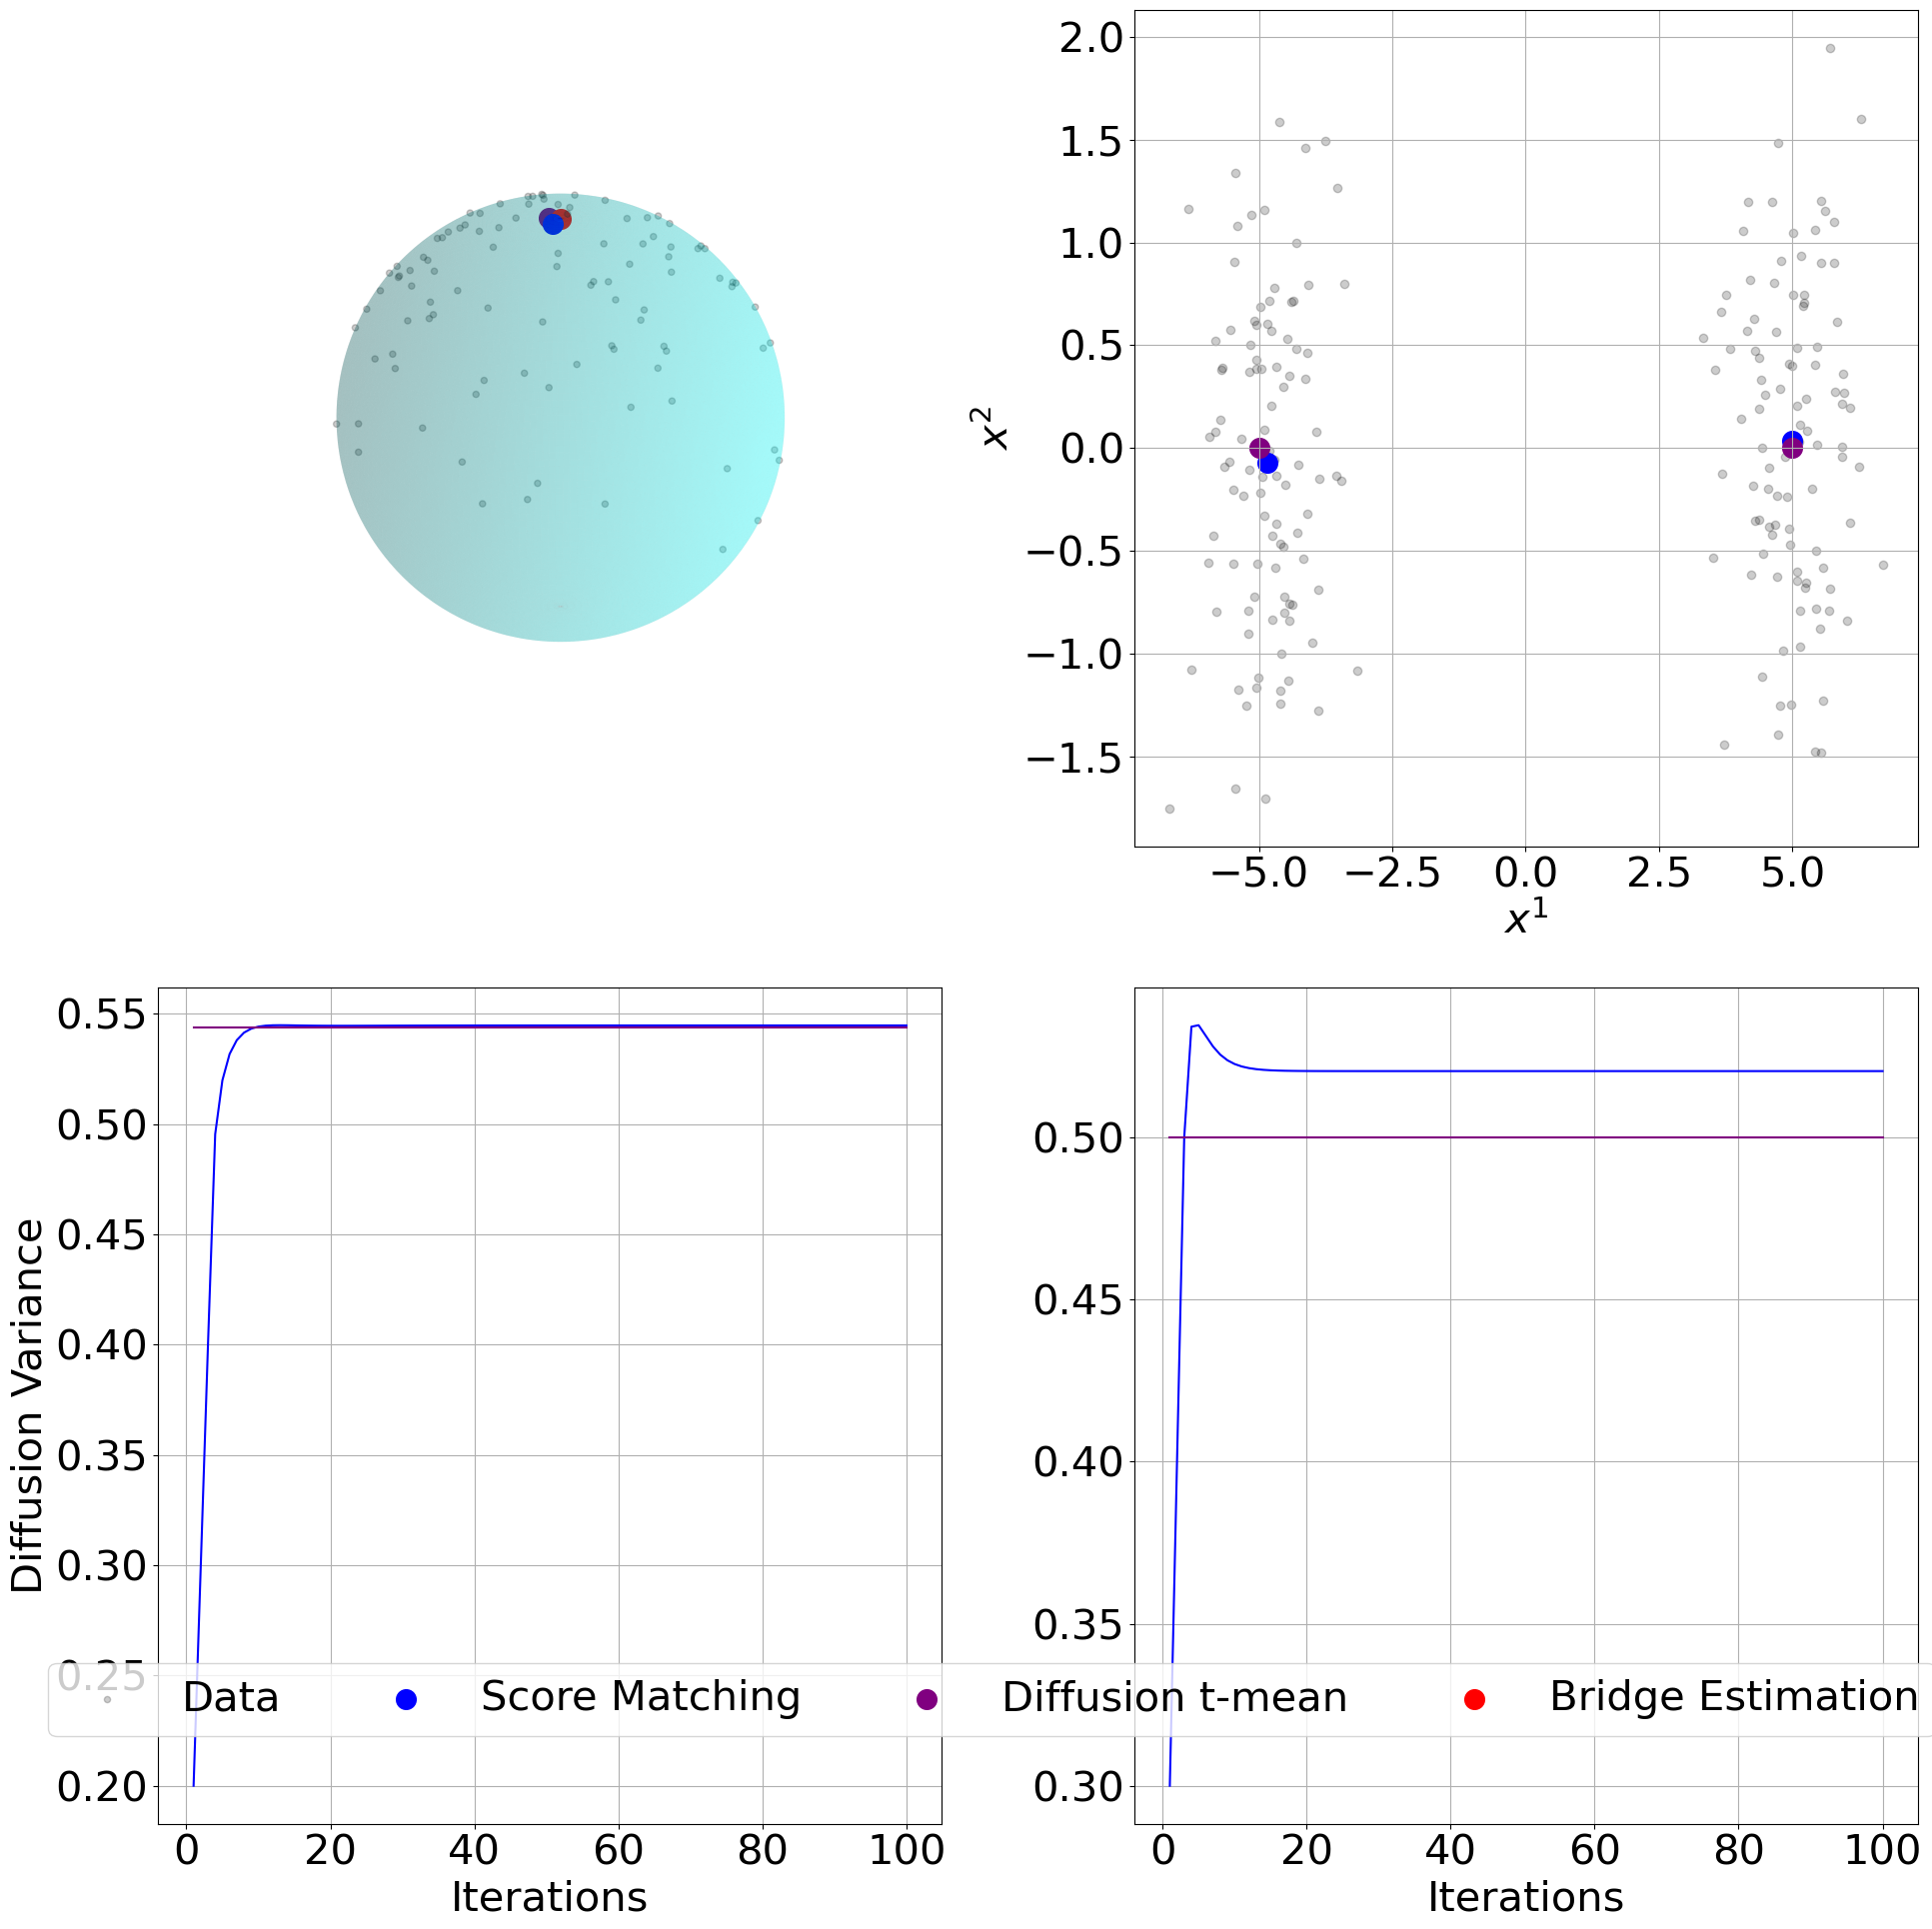

In [110]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(20,20))

#Landmarks
ax = fig.add_subplot(222)
obs = X_landmarks[0].reshape(100,2,2)
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.zeros(M.N))).T.flatten())
for i in range(len(obs)):
    plt.scatter(obs[i][0,0], obs[i][0,1], color='black', alpha=0.2)
    plt.scatter(obs[i][1,0], obs[i][1,1], color='black', alpha=0.2)
plt.scatter(mulandmarks_sm[0][-1].reshape(2,2)[0,0], mulandmarks_sm[0][-1].reshape(2,2)[0,1], color='blue', s=200)
plt.scatter(mulandmarks_sm[0][-1].reshape(2,2)[1,0], mulandmarks_sm[0][-1].reshape(2,2)[1,1], color='blue', s=200)
plt.scatter(x0[0].reshape(2,2)[0,0], x0[0].reshape(2,2)[0,1], color='purple', s=200)
plt.scatter(x0[0].reshape(2,2)[1,0], x0[0].reshape(2,2)[1,1], color='purple', s=200)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

ax = fig.add_subplot(224)
ax.plot(jnp.arange(1,len(Tlandmarks_sm)+1, 1), Tlandmarks_sm, color='blue')
ax.plot(jnp.arange(1,len(Tlandmarks_sm)+1, 1), 0.5*jnp.ones(len(Tlandmarks_sm)), color='purple')
ax.grid(True)
ax.set_xlabel('Iterations')
fig.tight_layout()

#S2
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(X_sphere[1][:,0], X_sphere[1][:,1], X_sphere[1][:,2], color='black', alpha=0.2, label='Data')
ax.scatter(musphere_sm[1][-1,0], musphere_sm[1][-1,1], musphere_sm[1][-1,2], color='blue', label='Score Matching', alpha=1.0, s=200)
ax.scatter(musphere_opt[1][-1,0], musphere_opt[1][-1,1], musphere_opt[1][-1,2], color='purple', label='Diffusion t-mean', s=200)
ax.scatter(musphere_bridghechart[-1,0], musphere_bridghechart[1,1], musphere_bridghechart[2,2], color='red', label='Bridge Estimation', s=200)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

ax = fig.add_subplot(223)
ax.plot(jnp.arange(1,len(Tsphere_sm)+1, 1), Tsphere_sm, color='blue')
ax.plot(jnp.arange(1,len(Tsphere_sm)+1, 1), Tsphere_opt[-1]*jnp.ones(len(Tsphere_sm)), color='purple')
ax.grid(True)
ax.set_xlabel('Iterations')
ax.set_ylabel('Diffusion Variance')
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.025,0.1), ncol=5)

plt.show()

fig.savefig('Figures/synthetic_data.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


## Conceptual Plot

### $\mathbb{S}^{2}$

In [171]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [172]:
file_path = 'scores/S2/'+ loss_type + '/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_s2(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log_s2(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log_s2(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [173]:
N_sim = 5
M = nSphere(N=2)
Brownian_coords(M)

(product, sde_product, chart_update_product) = product_sde(M, 
                                                           M.sde_Brownian_coords, 
                                                           M.chart_update_Brownian_coords)

x0 = M.coords([0.]*2)
x0s = tile(x0, N_sim)

_dts = dts(T=1.0, n_steps=1000)
dW = dWs(N_sim*M.dim,_dts).reshape(-1,N_sim,M.dim)
(ts,xss,chartss,*_) = product(x0s,
                              _dts,dW,jnp.repeat(1.,N_sim))
chartss = vmap(lambda x,y: vmap(lambda x,chart: M.F((x,chart)))(x,y))(xss, chartss)

t = ts[jnp.arange(200,len(ts)+200, 200)]
xs = xss[jnp.arange(200,len(xss)+200, 200)]
chart = chartss[jnp.arange(200,len(chartss)+200, 200)]

using M.Exp for Logarithm


In [255]:
N_sim = 5
M = nSphere(N=2)
Brownian_coords(M)

(product, sde_product, chart_update_product) = product_sde(M, 
                                                           M.sde_Brownian_coords, 
                                                           M.chart_update_Brownian_coords)

x0 = M.coords([0.]*2)
x0s = tile(x0, N_sim)

using M.Exp for Logarithm


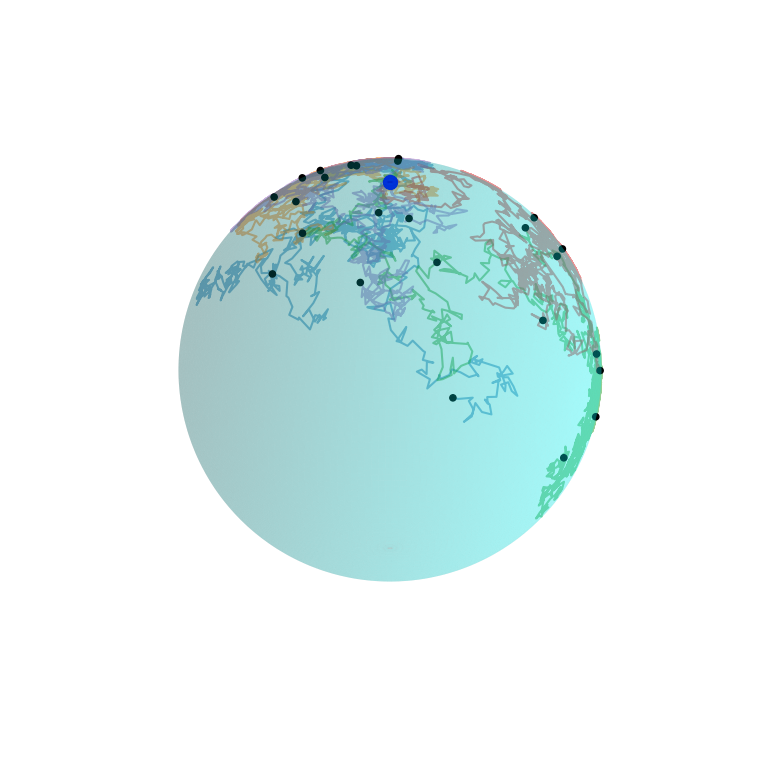

In [265]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(chart[:,:,0], chart[:,:,1], chart[:,:,2], color='black', alpha=1.0)
ax.scatter(x0[1][0], x0[1][1], x0[1][2], color='blue', alpha=1.0, s=100)
for i in range(N_sim):
    ax.plot3D(chartss[:,i,0], chartss[:,i,1], chartss[:,i,2], alpha=0.5)#, color='red', alpha=0.6)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

fig.savefig('Figures/s2_samples.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

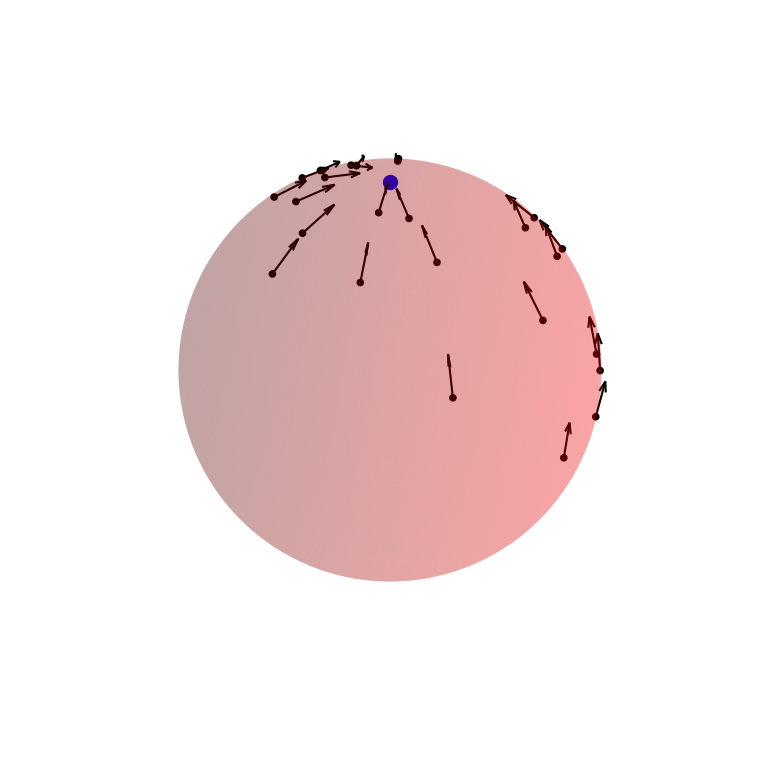

In [264]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

TM_grad_log = vmap(lambda x,chart,t: vmap(lambda x,y: M.grady_log_hk(x0,(x,y),t)[1])(x,chart))(xs,chart,t)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='red', alpha=0.2)
ax.scatter(chart[:,:,0], chart[:,:,1], chart[:,:,2], color='black', alpha=1.0)
ax.scatter(x0[1][0], x0[1][1], x0[1][2], color='blue', alpha=1.0, s=100)
ax.quiver(chart[:,:,0], chart[:,:,1], chart[:,:,2], 
          TM_grad_log[:,:,0], TM_grad_log[:,:,1], TM_grad_log[:,:,2], color='black', length=0.2, normalize=True)
#for i in range(N_sim):
#    ax.plot3D(chartss[:,i,0], chartss[:,i,1], chartss[:,i,2], alpha=0.5)#, color='red', alpha=0.6)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

fig.savefig('Figures/s2_gradients.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

# MNIST

## Defining Manifold and Loading Score

In [169]:
s1_path = ''.join(('scores/MNIST/',loss_type,'/'))
s2_path = 'scores/MNIST/s2/'

ds = load_mnist("train", 100, 2712)

state = load_model('ManLearn/models/MNIST/VAE/')
F = lambda x: mnist_decoder.apply(state.params, state.rng_key, x[0]).reshape(-1)

M = Latent(F=F,dim=2,emb_dim=28*28,invF=None)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)

N_dim = M.dim
x0 = mnist_encoder.apply(state.params, state.rng_key, next(ds).image)
x0 = M.coords(x0[0])

layers = [50,100,200,400,400,200,100,50]

s1_model = hk.transform(lambda x: models.MLP_s1(dim=N_dim, layers=layers)(x))
s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=N_dim, r = max(N_dim//2,1))(x))

using M.Exp for Logarithm


2023-10-11 16:17:13.455380: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [170]:
rng_key = jax.random.PRNGKey(2712)
s1_state = load_model(s1_path)
def grady_log(x,y,t):
    
    return s1_model.apply(s1_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1_model.apply(s1_state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1_model.apply(s1_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Loading Loss

In [171]:
loss = jnp.load('scores/MNIST/'+loss_type+'/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  90


## Estimating Diffusion t-Mean

In [172]:
X_obs = mnist_encoder.apply(state.params, state.rng_key, next(ds).image)
X_obs = vmap(lambda x: M.coords(x))(X_obs)

In [178]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.01, max_iter=1000)

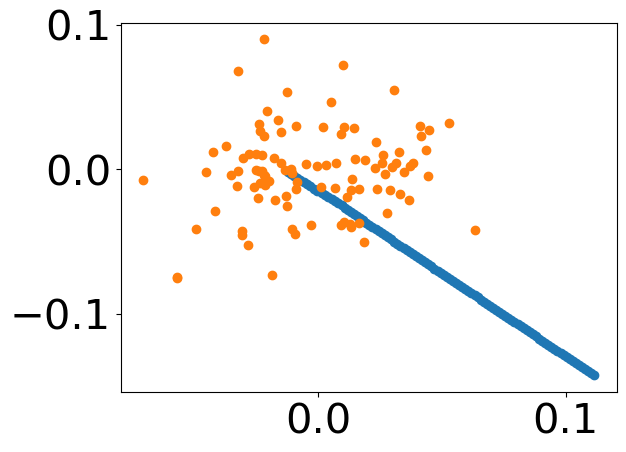

In [176]:
plt.scatter(mu_sm[0][:,0], mu_sm[0][:,1])
plt.scatter(X_obs[0][:,0], X_obs[0][:,1])

In [425]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.0161 
 -T error = 0.4990


In [427]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

26 s ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Plot Fréchet Mean

### $\mathbb{S}^{2}$

In [10]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [37]:
file_path = 'scores/S2/vsm/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [57]:
from scipy.io import loadmat

sphere_data = loadmat('../Data/sphere_walking/sphere_walking.mat', squeeze_me=True)
charts = jnp.array(sphere_data['data']).T
X_obs = vmap(lambda chart: get_coords(S2, chart))(charts)


In [12]:
xs = pd.read_csv('Data/S2/xs.csv', header=None)
charts = pd.read_csv('Data/S2/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [58]:
diffusion_mean.initialize(S2, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

In [59]:
mu_sm, __ = S2.sm_dmx(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.01]), 
                                     step_size=1.0, max_iter=100)

In [60]:
from jaxgeometry.statistics import Frechet_mean
Frechet_mean(S2)

mu_frechet,loss,iterations,vs = S2.Frechet_mean(zip(X_obs[0], X_obs[1]),S2_x0)

Step 0 | T: 0.000000e+00 | T: 1.461105e+00
Step 10 | T: 2.459770e+00 | T: 2.059321e-01
Step 20 | T: 1.489845e+00 | T: 7.549827e-02
Step 30 | T: 1.166201e+00 | T: 5.318150e-02
Step 40 | T: 1.659078e+00 | T: 5.535399e-02
Step 50 | T: 1.397619e+00 | T: 1.960845e-02
Step 60 | T: 1.424613e+00 | T: 2.001970e-02
Step 70 | T: 1.395694e+00 | T: 3.731182e-03
Step 80 | T: 1.374129e+00 | T: 2.209808e-03
Step 90 | T: 1.406553e+00 | T: 4.756989e-04
Step 100 | T: 1.375571e+00 | T: 5.093081e-04
Step 110 | T: 1.386221e+00 | T: 5.051283e-04
Step 120 | T: 1.377162e+00 | T: 9.629176e-05
Step 130 | T: 1.374994e+00 | T: 1.503273e-04
Step 140 | T: 1.382412e+00 | T: 5.975134e-05
Step 150 | T: 1.377753e+00 | T: 3.422765e-05
Step 160 | T: 1.377963e+00 | T: 4.510436e-05
Step 170 | T: 1.376544e+00 | T: 4.449688e-06
Step 180 | T: 1.376619e+00 | T: 1.352304e-05
Step 190 | T: 1.377792e+00 | T: 5.979408e-06
Step 199 | T: 1.377577e+00 | T: 5.407823e-06 


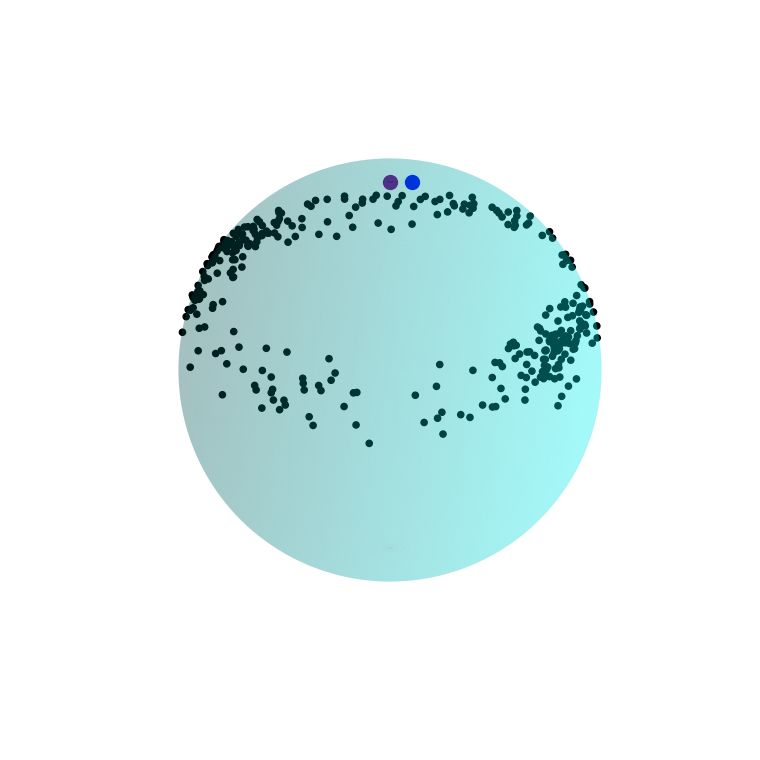

In [64]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(mu_sm[1][-1,0], mu_sm[1][-1,1], mu_sm[1][-1,2], color='blue', alpha=1.0, s=100)
ax.scatter(mu_frechet[1][0], mu_frechet[1][1], mu_frechet[1][2], color='purple', alpha=1.0, s=100)
ax.scatter(X_obs[1][:,0], X_obs[1][:,1], X_obs[1][:,2], color='black', alpha=1.0)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

fig.savefig('Figures/s2_frechet.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

## Plot Diffusion Mean

## Landmarks

In [78]:
data = pd.read_csv('../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt')

In [79]:
with open('../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt') as players_data:
    players_data.read()

In [80]:
players_data

<_io.TextIOWrapper name='../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt' mode='r' encoding='UTF-8'>

In [121]:
with open('../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]
    print(all_data[0])

"1039027751_0_default"	"x-coordinates"	971	933.1	902.8	867.3	827.9	787	741	695.8	645.9	593.9	538.3	479.3	416.7	381.5	387.1	410	443.8	462.7	467	467.7	489	531.8	593.1	658.1	720	720	672.6	628	595	565.1	538.8	538	523.5	554.1	552	601.4	598.8	631.7	673	713.7	754.8	794.9	818.9	868.9	890.7	904.5	919	934.1	948.2	961	1270	1335.1	1401.8	1468.1	1529.6	1558.9	1569.6	1574.1	1580.8	1610.3	1647	1664.3	1654.5	1593	1528	1467.6	1411.5	1358.3	1306.7	1258.9	1213.8	1170.4	1133.4	1096.5	1056	1045	1062.3	1070.1	1080.2	1089.8	1099.6	1120.3	1174.7	1194	1235	1279.8	1321.1	1363	1388.3	1416.1	1441.1	1455.8	1470.9	1464.5	1458.1	1435	1406	1365.1	1318.4	1271


In [122]:
test1 = jnp.array([int(float(x)) for x in all_data[0].split()[2:]])
test2 = jnp.array([int(float(x)) for x in all_data[1].split()[2:]])

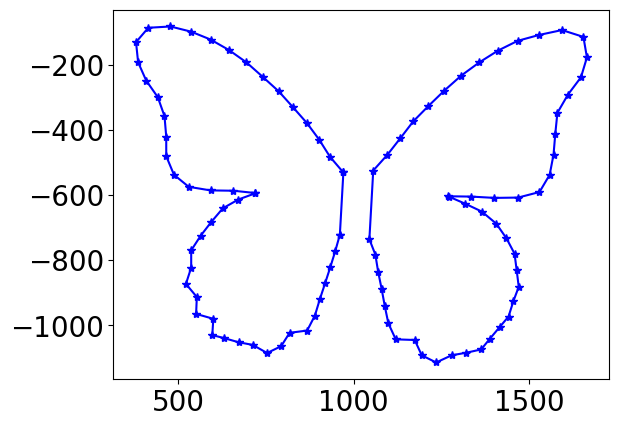

In [148]:
plt.plot(test1[:50:1],test2[:50:1], '-*', color='blue')
plt.plot(jnp.array([test1[0],test1[49]]), jnp.array([test2[0], test2[49]]), '-*', color='blue')
plt.plot(test1[50::1],test2[50::1], '-*', color='blue')

In [147]:
test1[0]

Array(971, dtype=int32)